# (30) Source data -- ```KABA```

**Motivation**: Save all the source data required for figures. This includes:

1. Degree ranks (Figure 6B)
2. Grads (Figure 8)
3. Coarse, n=128 (Supplementary Figure 2)

<br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display, Latex

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


from figures.fig_ocs import bwor_cmap


def _show_sim(
    sim, align: bool = False,
    figsize=(15, 5.1), fontsize=12, ):
    _n = len(list(sim.values())[0])
    ticklabels = np.array([f'G{i+1}' for i in range(_n)])
    fig, axes = create_figure(1, 3, figsize, 'all', 'all', 'constrained')
    
    for i, (k1, k2) in enumerate(itertools.combinations(grads, 2)):
        
        x = sim[(k1, k2)]
        if align:
            a, b = sp_optim.linear_sum_assignment(
                cost_matrix=np.abs(x), maximize=True)
            x = x[a][:, b]
            xticklabels = ticklabels[b]
            yticklabels = ticklabels[a]
        else:
            xticklabels = yticklabels = ticklabels
        
        ax = axes.flat[i]
        sns.heatmap(
            data=x,
            cmap=bwor_cmap('corr'),
            vmin=-1,
            vmax=1,
            linewidths=0.2,
            linecolor='dimgrey',
            cbar=False,
            square=True,
            annot=True,
            fmt="0.2f",
            annot_kws={'fontsize': fontsize},
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax,
        )
        ax.set_ylabel(k1, fontsize=25)
        ax.set_xlabel(k2, fontsize=25, labelpad=12)
        ax.tick_params(labelsize=17)
    return fig


def _show_scatter(df, mode):
    fig, axes = create_figure(4, 4, (9.5, 9.5), layout='constrained')

    d2p = df.loc[df['mode'] == mode]
    for i, j in itertools.product(range(4), range(4)):
        ax = axes[i, j]
        sns.scatterplot(
            data=d2p,
            y=f'G-{i+1}',
            x=f'G-{j+1}',
            hue='partition',
            hue_order=colors,
            palette=colors,
            ax=ax,
        )
        move_legend(ax)
        ax_square(ax)

    for i, j in list(zip(*np.tril_indices(4, k=-1))):
        axes[i, j].remove()

    plt.show()
    return fig


def _show_grads(x):
    _n = x.shape[1]
    fig, _ = bs.show(
        data={
            k: x[i] for i, k in
            enumerate(grads)},
        vmin=-2.0, vmax=2.0, figsize=(1.8 * _n, 4.5), dpi=180,
        titles=[f"G-{i+1}" for i in range(_n)],
        cbar=True, cbar_pad=0.12, cbar_aspect=15, cbar_shrink=0.8,
        label_pad=15, label_fontsize=16,
        cmap='Spectral_r', contour_cmap='Greys_r',
        layout='constrained',
    )
    return fig


def _show_grads_save(x):
    _n = x.shape[1]
    fig, _ = bs.show(
        data={
            k: x[i] for i, k in
            enumerate(grads)},
        vmin=-2.0, vmax=2.0, figsize=(1.8 * _n, 4.5), dpi=180,
        titles=False, add_ylabels=False, cbar=False,
        cmap='Spectral_r', contour_cmap='Greys_r',
        layout='constrained', wscape=0, hspace=0,
    )
    return fig


def _show_lambs(lambs):
    fig, axes = create_figure(1, 3, (9, 2.8), sharex='all', layout='constrained')

    g_both = {}
    for i, (k, v) in enumerate(lambs.items()):
        axes[i].axvline(4, color='k', ls='--', lw=1, label='cutoff')
        axes[i].plot(
            range(1, len(v) + 1), v,
            marker='o', markersize=5,
            lw=1, color=pal[k], label=k)
        axes[i].legend(fontsize=13, loc='best')
        axes[i].grid()
    axes[0].set(xscale='log')
    plt.show()
    return fig


def _show_lambs_shared(lambs, figsize=(4, 3)):
    fig, ax = create_figure(1, 1, figsize)
    ax.axvline(4, color='k', ls='--', lw=1, label='cutoff')

    g_both = {}
    for i, (k, v) in enumerate(lambs.items()):
        x = v / sum(v)
        x *= 100
        ax.plot(
            range(1, len(v) + 1), x,
            marker='o', markersize=5,
            lw=1.3, color=pal[k], label=k)
        ax.legend(fontsize=13, loc='best')
    ax.set(xscale='log', xlabel='', ylabel='')
    ax.grid()
    # ax.set_xlabel('Component', fontsize=13)
    # ax.set_ylabel('Variance [%]', fontsize=13)
    plt.show()
    return fig


def get_sim(x, labels):
    _n = x.shape[1]
    sim = {
        (k1, k2): np.zeros((_n, _n)) for k1, k2
        in itertools.product(labels, labels)
    }
    for i0, j0 in itertools.product(range(3), range(3)):
        for i1, j1 in itertools.product(range(_n), range(_n)):
            key = (labels[i0], labels[j0])
            sim[key][i1, j1] = sp_stats.pearsonr(
                x[i0, i1], x[j0, j1],
            ).statistic
    return sim


def get_x2p(g, num=7, zscore=True, delete={BOLD: 2, CAS: 7, CAF: 7}):
    x2p = np.zeros((3, 8, bs.num_n))
    for i, (mode, x) in enumerate(g.items()):
        for j in range(8):
            _x = x[j]
            if zscore:
                x2p[i, j] = sp_stats.zscore(_x)
            else:
                x2p[i, j] = _x
    
    if delete is not None:
        x2p_final = np.zeros((3, 7, bs.num_n))
        for i, i_del in enumerate(delete.values()):
            ids = np.delete(np.arange(8), i_del)
            x2p_final[i] = x2p[i][ids]
    else:
        x2p_final = x2p
    x2p_final[1, 0] *= -1
    x2p_final[1, 2] *= -1
    return x2p_final[:, :num, :]


def get_df(x, partition, labels):
    df = []
    for i, mode in enumerate(labels):
        good = np.isfinite(partition[mode])
        disjoint = [
            f"OC-{i:0.0f}" for i in
            partition[mode][good]
        ]
        df.append({
            'mode': [mode] * good.sum(),
            'partition': disjoint,
            'G-1': x[i][0, good],
            'G-2': x[i][1, good],
            'G-3': x[i][2, good],
            'G-4': x[i][3, good],
        })
    df = pd.DataFrame(merge_dicts(df))
    return df

## Prep

In [3]:
mice = Mice(512)
bs = Base(mice, mode='ca2')
kws_show = show_kws(7)

pal = prepare_palette()
cmap, colors = get_cluster_cmap(range(7), return_colors=True)
colors = {f"OC-{i+1}": c for i, c in enumerate(colors)}
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

save_dir = pjoin(fig_base_dir, 'rebuttal', 'source_data')
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal/source_data

## Degree ranks

In [4]:
dr = np.load(
    pjoin(tmp_dir, 'degree_ranks.npy'),
    allow_pickle=True,
).item()

### Plot (for the recod)

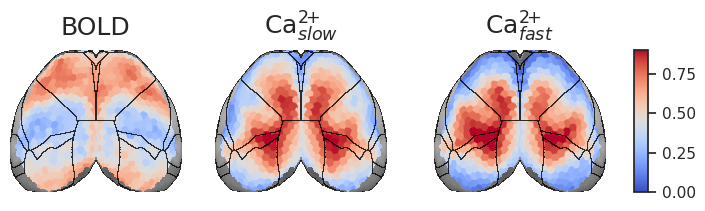

In [5]:
fig, _ = bs.show(
    data=np.stack([v for v in dr.values()]),
    titles=[translation[k] for k in dr],
    figsize=(7, 2.0), vmin=0, vmax=0.9, 
    label_fontsize=18, title_y=1.05,
    cbar_pad=0.15, cbar=True, cbar_aspect=10,
    cmap='coolwarm', contour_cmap='Greys_r',
    layout='constrained',
)

### Save CSV

In [6]:
sd = pd.DataFrame(dr)
sd.to_csv(pjoin(save_dir, "Fig6B.csv"), index=False)

## Grads

In [7]:
hemis = 'both'

# grads & lambs
grads = np.load(
    pjoin(tmp_dir, 'grads.npy'),
    allow_pickle=True,
).item()
lambs = grads['lambs'][hemis]
grads = grads['grads'][hemis]

# pi & partition
pi = np.load(
    pjoin(tmp_dir, 'memberships_avg.npy'),
    allow_pickle=True,
).item()
partition = {
    mode: bs.disjoint_community(pi[f"preproc\n{mode}"])
    for mode in grads
}

### 4 x grads

In [8]:
num = 4
x = get_x2p(grads, num, zscore=True)

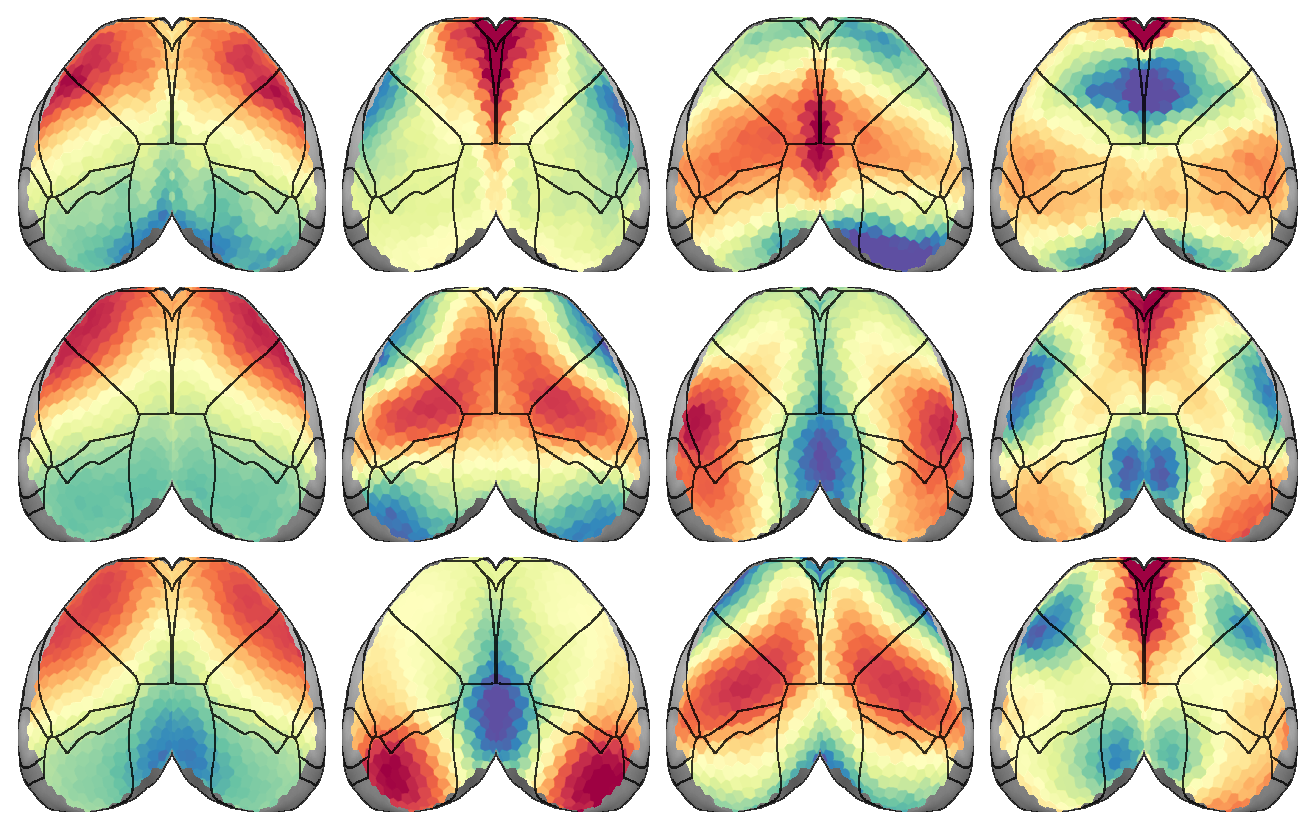

In [9]:
fig = _show_grads_save(x)

### Similarity

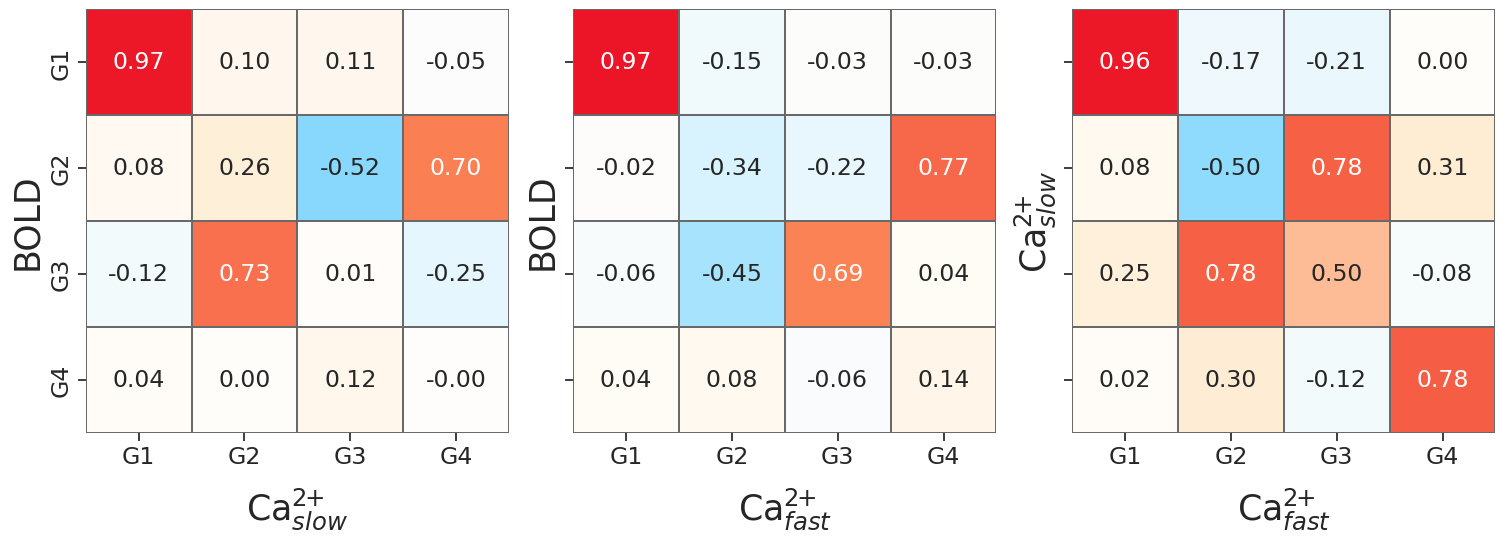

In [10]:
sim = get_sim(x, list(grads))
fig = _show_sim(sim, align=False, fontsize=17, figsize=(15, 5.3))

### Pairwise scatter

In [11]:
df = get_df(x, partition, list(grads))

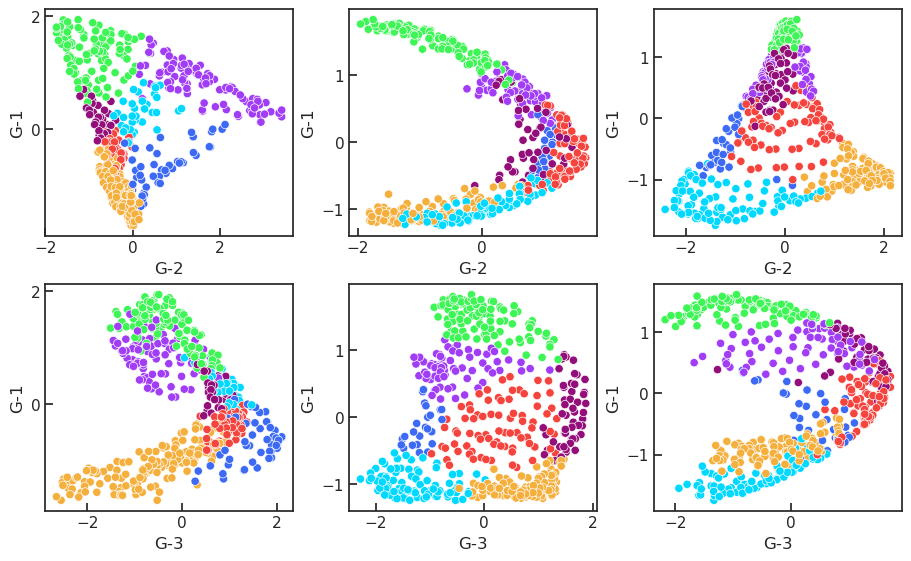

In [12]:
fig, axes = create_figure(2, 3, (9, 5.5), layout='constrained')
for row_i, (i, j) in enumerate([(0, 1), (0, 2)]):
    for col_i, mode in enumerate(grads):
        ax = axes[row_i, col_i]
        d2p = df.loc[df['mode'] == mode]
        sns.scatterplot(
            data=d2p,
            y=f"G-{i+1}",
            x=f"G-{j+1}",
            hue='partition',
            hue_order=colors,
            palette=colors,
            legend=False,
            ax=ax,
        )
        ax.locator_params(nbins=3)
        ax.tick_params(direction="in")
        # ax.set(xlabel='', ylabel='')
plt.show()

### Save Excel

In [13]:
df.to_excel(pjoin(save_dir, "Figure8.xlsx"), index=False)

### Lamb (not saved)

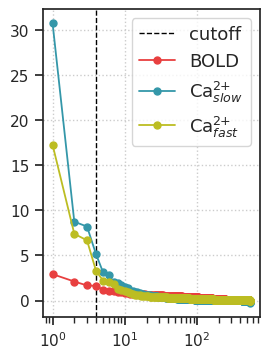

In [14]:
fig = _show_lambs_shared(lambs, (2.8, 4))

## Supplementary Figure 3

In [4]:
load_dir_8x = pjoin(fig_base_dir, 'paper2.0', '8x')
results512 = np.load(pjoin(load_dir_8x, f'4x_n512.npy'), allow_pickle=True).item()
results128 = np.load(pjoin(load_dir_8x, f'4x_n128.npy'), allow_pickle=True).item()

### Extract scores/pvals

In [5]:
reord = list(range(5)) + [6, 5, 7]
scores, std_err = {}, {}

for kk in [3, 7, 20]:
    scores[kk] = np.concatenate([
        results512['scores_dict'][kk],
        results128['scores_dict'][kk],
    ], axis=1)[:, reord, :]
    std_err[kk] = np.concatenate([
        results512['std_err_dict'][kk],
        results128['std_err_dict'][kk],
    ], axis=0)[reord]

In [6]:
pvalue = np.concatenate([
    results512['pvalue'],
    results128['pvalue'],
], axis=-1)[:, reord]
statistic = np.concatenate([
    results512['statistic'],
    results128['statistic'],
], axis=-1)[:, reord]
pvalue.shape, statistic.shape

((3, 8), (3, 8))

### Get condition labels

In [7]:
conds = []
for i, j in itertools.combinations([BOLD, CAS, CAF], 2):
    conds.append((i, j))
conds

[
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'),
    ('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
]

### Create scores df

In [8]:
x_axis_labels = itertools.product(['Fine', 'Coarse'], [10, 15, 20, 25])
x_axis_labels = [
    f'{lbl}_d={d}%' for
    lbl, d in x_axis_labels
]
x_axis_labels

[
    'Fine_d=10%',
    'Fine_d=15%',
    'Fine_d=20%',
    'Fine_d=25%',
    'Coarse_d=10%',
    'Coarse_d=15%',
    'Coarse_d=20%',
    'Coarse_d=25%'
]

In [9]:
df = []
for kk, v in scores.items():
    for i, x_lbl in enumerate(x_axis_labels):
        for j, cond in enumerate(conds):
            _a = v[:, i, j]
            df.append({
                'K': [kk] * len(_a),
                'condition': [x_lbl] * len(_a),
                'comparison': [' vs. '.join(cond)] * len(_a),
                'animal': range(1, len(_a) + 1),
                'cos_sim': _a,
            })
df = pd.DataFrame(merge_dicts(df))

###  Get pvals df

In [10]:
comparison = (BOLD, CAS), (BOLD, CAF)
comparison_name = ' vs. '.join([
    f"({comparison[0][0]} vs. {comparison[0][1]})",
    f"({comparison[1][0]} vs. {comparison[1][1]})",
])

In [11]:
df_pvals = []
for i, kk in enumerate(scores):
    _a = pvalue[i]
    df_pvals.append({
        'K': [kk] * len(_a),
        'condition': x_axis_labels,
        'comparison': [comparison_name] * len(_a),
        'animal': ['group'] * len(_a),
        'p-value': _a,
    })
df_pvals = pd.DataFrame(merge_dicts(df_pvals))

### Concat, save

In [12]:
df = pd.concat([df, df_pvals])
df.to_excel(pjoin(save_dir, "SupplementaryFigure3.xlsx"), index=False)

## Supplementary Figure 5

In [33]:
pi_awake = np.load(
    pjoin(tmp_dir, 'memberships_awake_avg.npy'),
    allow_pickle=True,
).item()

pi_anesth_subset = np.load(
    pjoin(tmp_dir, 'memberships.npy'),
    allow_pickle=True,
).item()

pi_anesth_subset = {
    k: bn.nanmean(v[np.array([2, 6, 7, 9, 10]) - 1], 0)
    for k, v in pi_anesth_subset.items()
    if 'preproc' in k and
    'BOLD' not in k
}

pi_combined = {
    **pi_anesth_subset,
    **pi_awake,
}

order = [
    f"preproc\n{CAS}", f"awake\n{CAS}",
    f"preproc\n{CAF}", f"awake\n{CAF}",
]
pi_combined = {k : pi_combined.get(k) for k in order}

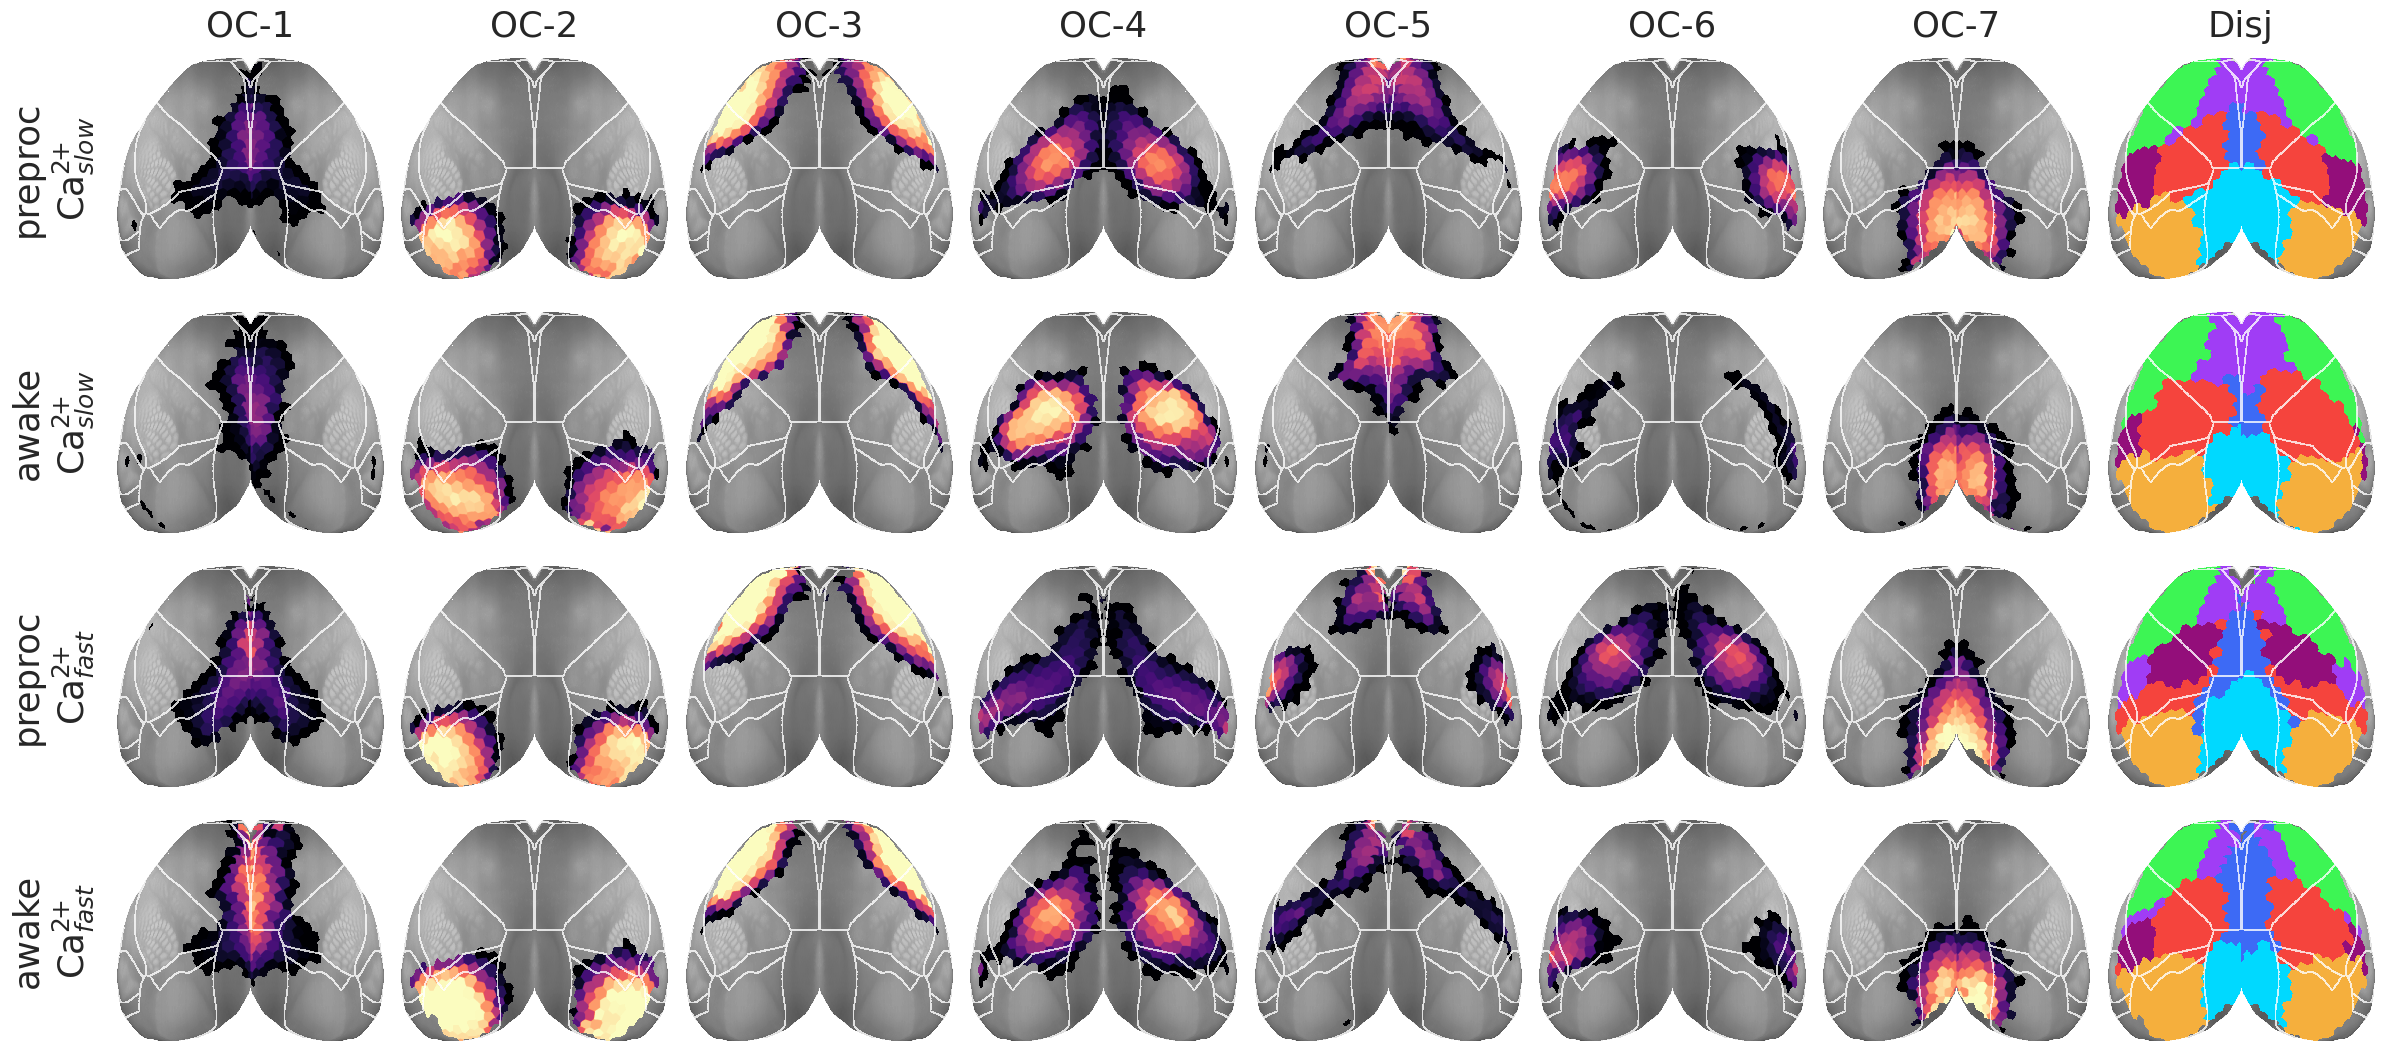

In [34]:
kws_show.update(dict(
    add_ylabels=True,
    titles=True,
    display=True,
))
fig, axes = bs.show(pi_combined, **kws_show)

In [35]:
df = []
for k, x in pi_combined.items():
    if 'preproc' in k:
        label = 'Anesthetized'
    elif 'awake' in k:
        label = 'Awake'
    else:
        raise ValueError()
    mode = CAS if CAS in k else CAF
    for i, a in enumerate(x):
        df.append({
            'condition': [label] * len(a),
            'mode': [mode] * len(a),
            'node': range(len(a)),
            'OC': [i + 1] * len(a),
            'pi': a,
        })
df = pd.DataFrame(merge_dicts(df))

### Save

In [36]:
df.to_excel(pjoin(save_dir, "SupplementaryFigure5.xlsx"), index=False)

## Supplementary Figure 6

In [145]:
pi_hrf = np.load(pjoin(tmp_dir, 'memberships_avg.npy'), allow_pickle=True).item()
pi_hrf = {k: v for k, v in pi_hrf.items() if 'hrf' in k}

# scores / pvals:
hrf_scores_pvals = np.load(pjoin(tmp_dir, 'hrf_pvals.npy'), allow_pickle=True).item()

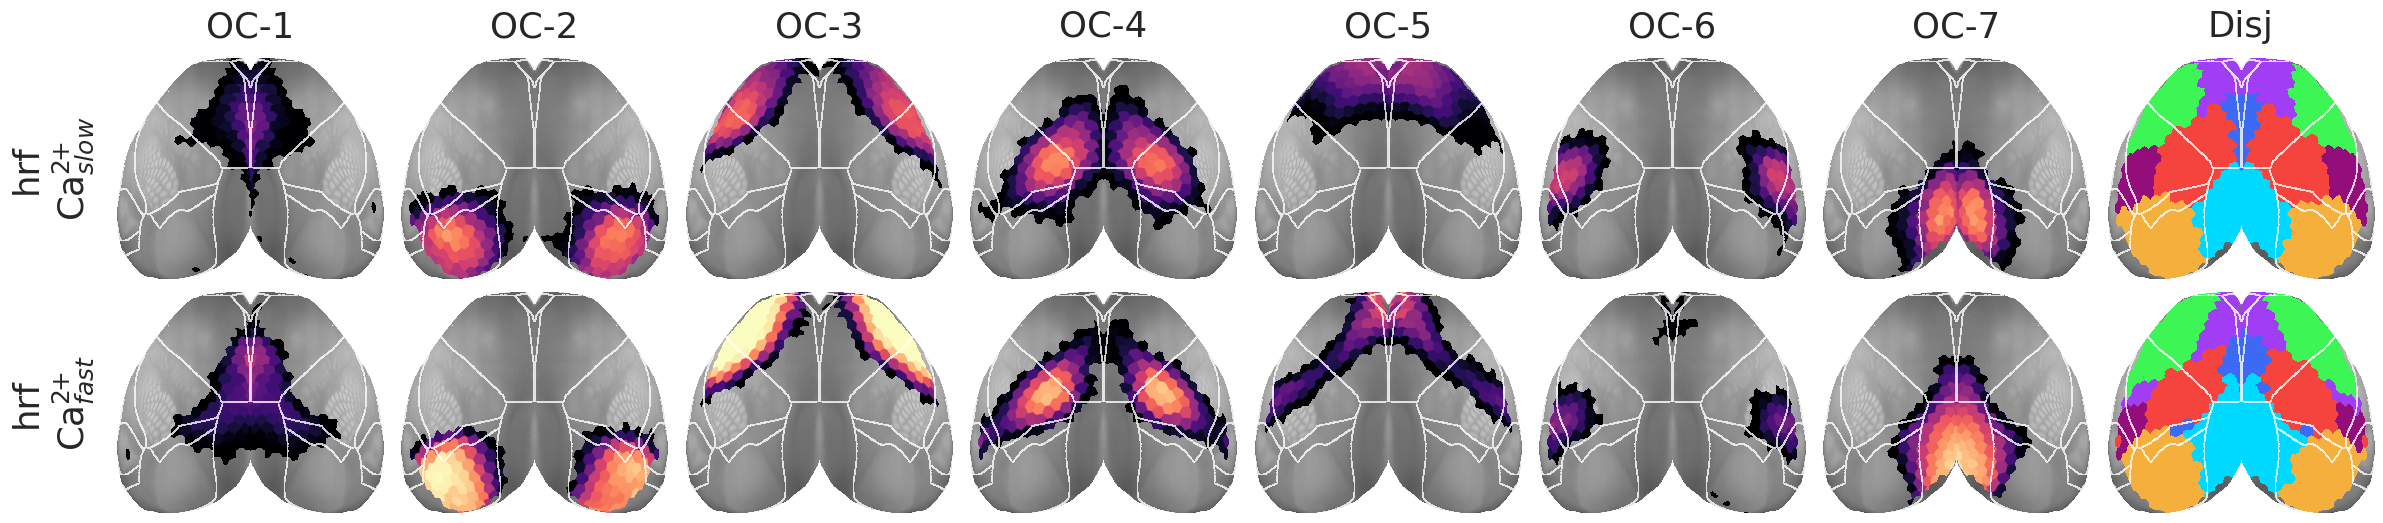

In [146]:
kws_show.update(dict(
    add_ylabels=True,
    titles=True,
    display=True,
))
fig, axes = bs.show(pi_hrf, **kws_show)

### Supp6A

In [147]:
df = []
for k, x in pi_hrf.items():
    mode = CAS if CAS in k else CAF
    for i, a in enumerate(x):
        df.append({
            'condition': ['Ca-HRF'] * len(a),
            'mode': [mode] * len(a),
            'node': range(len(a)),
            'OC': [i + 1] * len(a),
            'pi': a,
        })
df = pd.DataFrame(merge_dicts(df))
df.to_csv(pjoin(save_dir, 'SuppFig6A.csv'), index=False)

### Supp6B

In [148]:
list(hrf_scores_pvals)

['results_final', 'results_overall_final', 'test_to_save']

In [149]:
df = []
for k, v in hrf_scores_pvals['results_final']['sim'].items():
    for anim_i, a in enumerate(v):
        _a = np.diagonal(a)
        df.append({
            'comparison': [' vs. '.join(k)] * len(_a),
            'animal': [anim_i] * len(_a),
            'OC': range(1, len(_a) + 1),
            'cos_sim': _a,
        })
df = pd.DataFrame(merge_dicts(df))

In [150]:
p = np.array([
    [1.99998000e-05, 2.82277177e-01, 8.00991990e-02, 3.28756712e-01,
     2.23997760e-03, 1.42937701e-01, 1.99998000e-05],
    [1.39442606e-02, 1.25498745e-01, 1.31798682e-01, 1.99998000e-05,
     1.99998000e-05, 1.93331400e-04, 1.99998000e-05]
])

In [151]:
reject, *_ = multipletests(pvals=p.ravel(), method='fdr_bh', alpha=0.05)
reject = reject.reshape(p.shape)
reject

array([[ True, False, False, False,  True, False,  True],
       [ True, False, False,  True,  True,  True,  True]])

In [152]:
order = [
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')
]
selected_tests = [
    (order[0], order[1]),
    (order[2], order[3]),
]

In [153]:
df_pvals = []
for i, comparison in enumerate(selected_tests):
    comparison_name = ' vs. '.join([
        f"({comparison[0][0]} vs. {comparison[0][1]})",
        f"({comparison[1][0]} vs. {comparison[1][1]})",
    ])
    df_pvals.append({
        'comparison': [comparison_name] * p.shape[1],
        'animal': ['group'] * p.shape[1],
        'OC': range(1, p.shape[1] + 1),
        'p-value': p[i],
    })
df_pvals = pd.DataFrame(merge_dicts(df_pvals))

#### Concat, save

In [154]:
df = pd.concat([df, df_pvals])
df.to_csv(pjoin(save_dir, 'SuppFig6B.csv'), index=False)

### Supp6C

In [155]:
df = []
for k, _a in hrf_scores_pvals['results_overall_final'][7]['sim_overall'].items():
    df.append({
        'comparison': [' vs. '.join(k)] * len(_a),
        'K': [7] * len(_a),
        'cos_sim': _a,
    })
df = pd.DataFrame(merge_dicts(df))

In [156]:
p = [0.1154263214, 0.0246849201]
multipletests(pvals=p, method='fdr_bh', alpha=0.05)

(
    array([False,  True]),
    array([0.11542632, 0.04936984]),
    0.025320565519103666,
    0.025
)

In [157]:
order = [
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{slow}$ (HRF)'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$'),
    ('BOLD', 'Ca$^{2\\!\\!+}_{fast}$ (HRF)')
]
selected_tests = [
    (order[0], order[1]),
    (order[2], order[3]),
]

In [158]:
df_pvals = []
for i, comparison in enumerate(selected_tests):
    comparison_name = ' vs. '.join([
        f"({comparison[0][0]} vs. {comparison[0][1]})",
        f"({comparison[1][0]} vs. {comparison[1][1]})",
    ])
    df_pvals.append({
        'comparison': [comparison_name],
        'K': [7],
        'p-value': [p[i]],
    })
df_pvals = pd.DataFrame(merge_dicts(df_pvals))

#### Concat, save

In [159]:
df = pd.concat([df, df_pvals])
df.to_csv(pjoin(save_dir, 'SuppFig6C.csv'), index=False)

## Supplementary Figure 7

In [49]:
from analysis.lfr import mk_lfr, load_lfr, extract_true_k, compile_lfr_results

lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')
mode2lbl = {BOLD: 'BO', CAS: 'CAS', CAF: 'CAF'}

In [50]:
len(os.listdir(pjoin(lfr_dir, 'results')))

2320

In [51]:
counts = []
for item in sorted(os.listdir(pjoin(lfr_dir, 'results'))):
    _dir = pjoin(lfr_dir, 'results', item)
    counts.append(len(os.listdir(_dir)))
collections.Counter(counts).most_common()

[(105, 2320)]

In [52]:
%%time

lfr_sv = compile_lfr_results(lfr_dir)
len(lfr_sv)

on87-om4-mu0.1_ca2_sub-SLC10_ses-3_run-7: 100%|██████████| 2320/2320 [1:35:35<00:00,  2.47s/it]      

CPU times: user 9h 51min 36s, sys: 20h 25min 23s, total: 1d 6h 16min 59s
Wall time: 1h 35min 35s


10

In [58]:
save_obj(
    obj=lfr_sv,
    file_name='lfr_sv',
    save_dir=tmp_dir,
    mode='npy',
);

[PROGRESS] 'lfr_sv.npy' saved at
/home/hadi/Dropbox/git/jb-Ca-fMRI/tmp

In [54]:
%%time

df = []
bins = np.linspace(0.2, 1.0, 5)
for k, v in lfr_sv.items():
    of, om, mu = map(
        lambda s: float(re.sub('[a-zA-Z]', '', s)),
        k.split('-'),
    )
    of = np.round(of, 1)
    tag = 'Disjoint' if of == 0 else 'Overlapping'
    for name, x in v.items():
        lbl = name.split('_')[0]
        key = '_'.join(name.split('_')[1:])
        pi = x / np.sum(x, axis=1, keepdims=True)
        cut = cut_data(
            data=pi,
            bins=bins,
            axis_oc=1,
            axis_node=2,
            axis_batch=0,
            oc_only=True,
        )[0]
        cut = {
            i + 1: x for i, x in
            enumerate(avg(cut, 1))
        }
        df.append({
            'mu': [mu] * len(cut),
            'of': [of] * len(cut),
            'om': [om] * len(cut),
            'Label': [tag] * len(cut),
            'lbl': [lbl] * len(cut),
            'key': [key] * len(cut),
            'bin_idx': cut.keys(),
            'portion': cut.values(),
        })
df = pd.DataFrame(merge_dicts(df))

CPU times: user 1min 55s, sys: 1.36 s, total: 1min 56s
Wall time: 1min 56s


In [59]:
list(cut)

[1, 2, 3, 4]

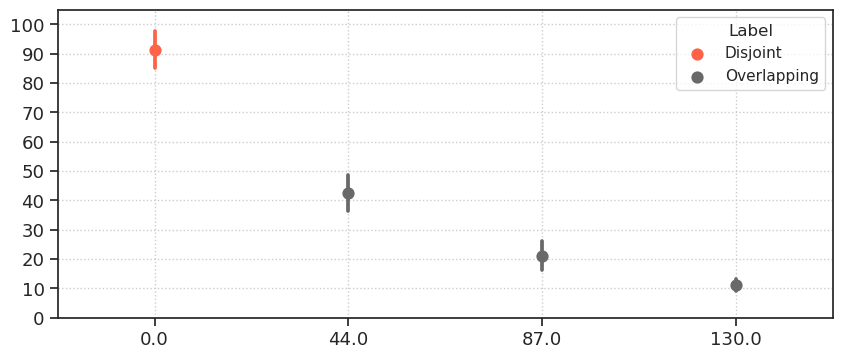

In [55]:
fig, ax = create_figure(1, 1, (10, 4))

_df = df.loc[df['bin_idx'] == 4]
sns.pointplot(
    data=_df,
    ci='sd',
    x='of',
    y='portion',
    hue='Label',
    join=False,
    palette={'Disjoint': 'tomato', 'Overlapping': 'dimgrey'},
    ax=ax
)
ax.set(ylim=(0, 105), xlabel='', ylabel='')
ax.locator_params(axis='y', nbins=11)
ax.set_xticklabels(([
    np.round(float(t.get_text()), 1)
    for t in ax.get_xticklabels()
]))
ax.tick_params(axis='both', labelsize=13)
ax.grid()
# fig.savefig(pjoin(fig_dir, 'lastbin.pdf'), **kws_fig)
plt.show()

In [60]:
_df['of'].unique()

array([  0.,  44.,  87., 130.])

In [61]:
means = dict(_df.groupby(['of']).mean()['portion'])
means

{
    0.0: 91.41444735599944,
    44.0: 42.63063180833032,
    87.0: 21.236400361357962,
    130.0: 11.264025937689608
}

## Combine using pd.ExcelWriter

In [160]:
combine = {
    'SuppFig2': ['A', 'C', 'E', 'F'],
    'SuppFig6': ['A', 'B', 'C'],
    'SuppFig8': ['A', 'B'],
    'SuppFig9': ['A', 'B'],
    'SuppFig10': ['A', 'B'],
    'SuppFig11': ['A', 'B', 'C'],
}
for f, panels in combine.items():
    dfs = {}
    for p in panels:
        dfs[p] = pd.read_csv(pjoin(save_dir, f"{f}{p}.csv"))

    name = f"{f}.xlsx".replace('SuppFig', 'SupplementaryFigure')
    file = pjoin(save_dir, name)
    with pd.ExcelWriter(file) as writer:
        for p, df in dfs.items():
            df.to_excel(writer, sheet_name=f"{f}-{p}")

## Supplementary Figure 2

### Loads GABAN

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(tmp_dir, '_Ca-fMRI-Feb11'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

### Prep from GABAN

In [2]:
nn = 512
num_k = 7
perc = 15
kws_show = show_kws(num_k)

pal = prepare_palette()
cmap, colors = get_cluster_cmap(range(7), return_colors=True)
colors = {f"OC-{i+1}": c for i, c in enumerate(colors)}
translation = {'BOLD': BOLD, 'CAS': CAS, 'CAF': CAF}

save_dir = pjoin(fig_base_dir, 'rebuttal', 'source_data')
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/rebuttal/source_data

## Get the actual fig

In [3]:
nn = 128
mice = Mice(nn)

perc = 20
num_k = 20

In [4]:
final_perm={4: 6, 5: 4, 6: 5}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(7)
}
final_perm

{0: 0, 1: 1, 2: 2, 3: 3, 4: 6, 5: 4, 6: 5}

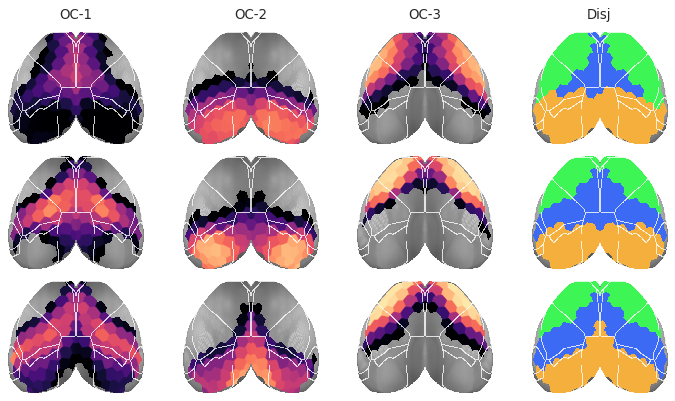

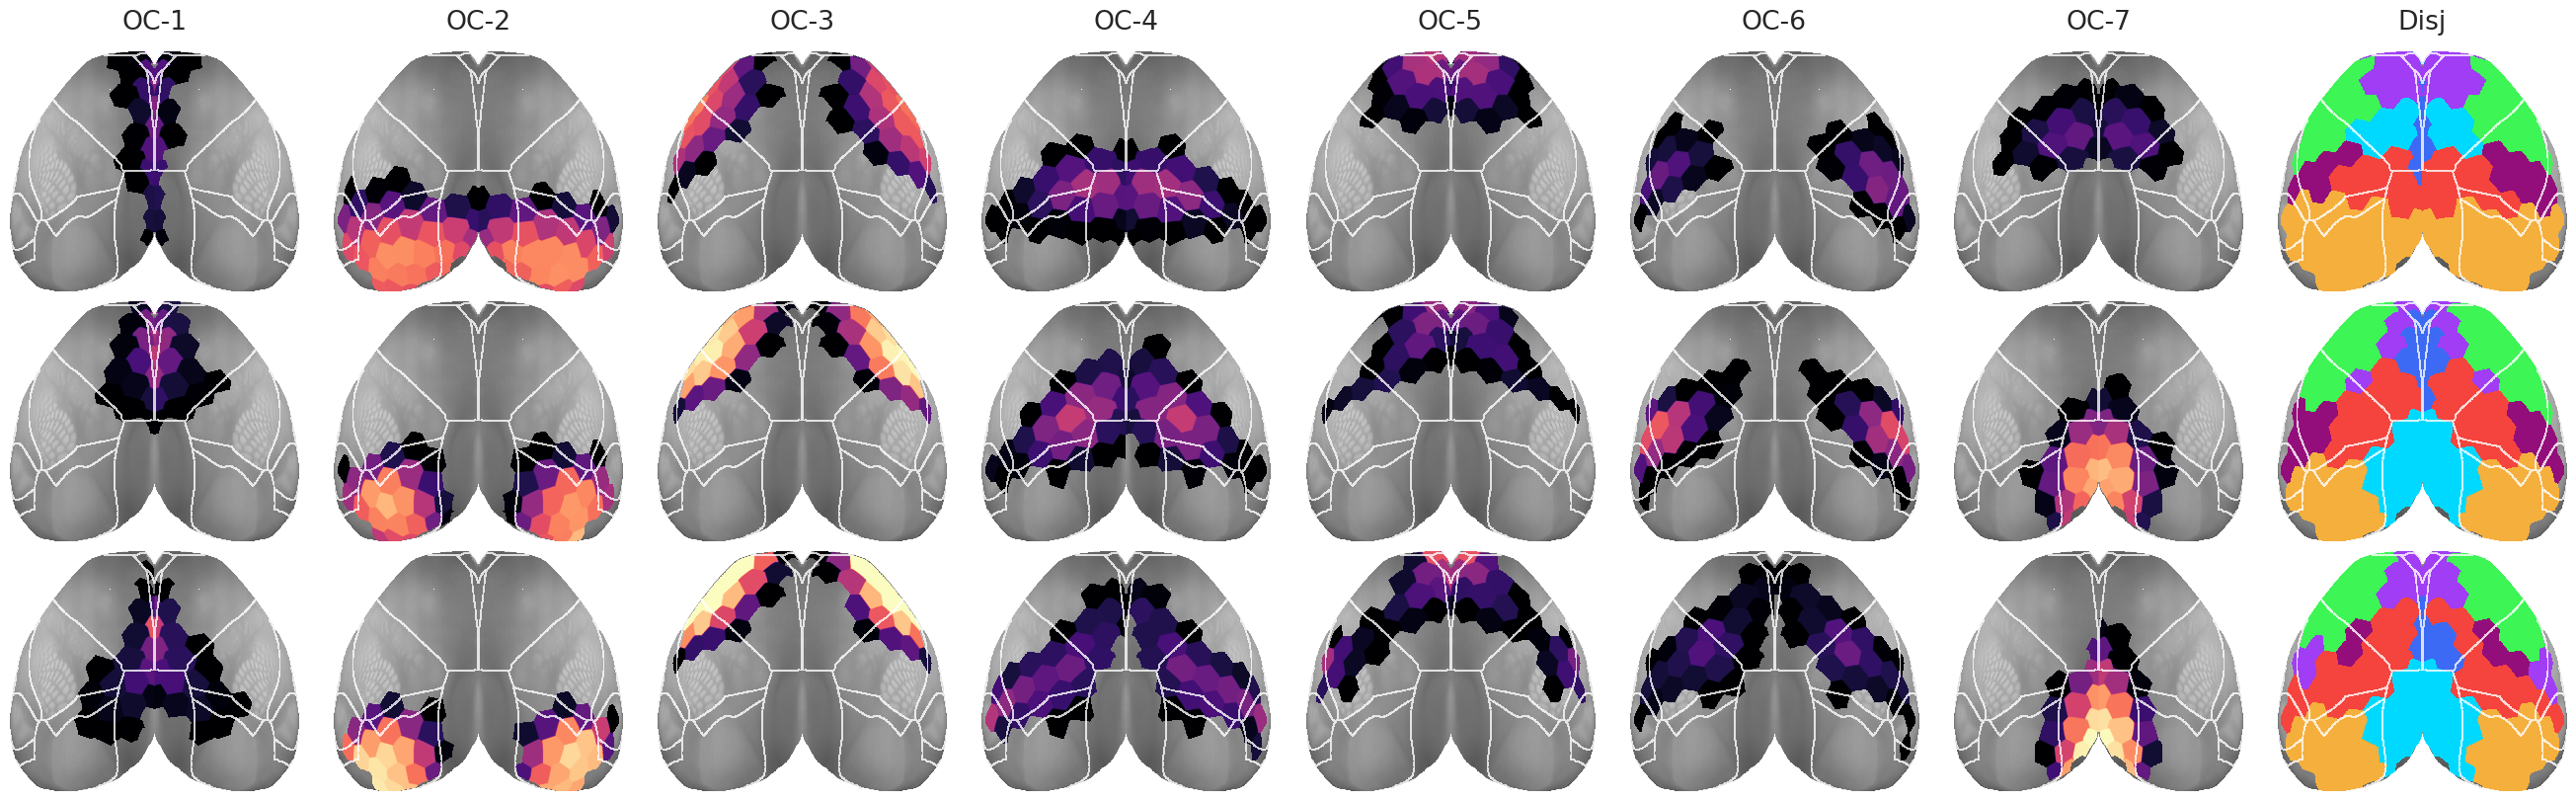

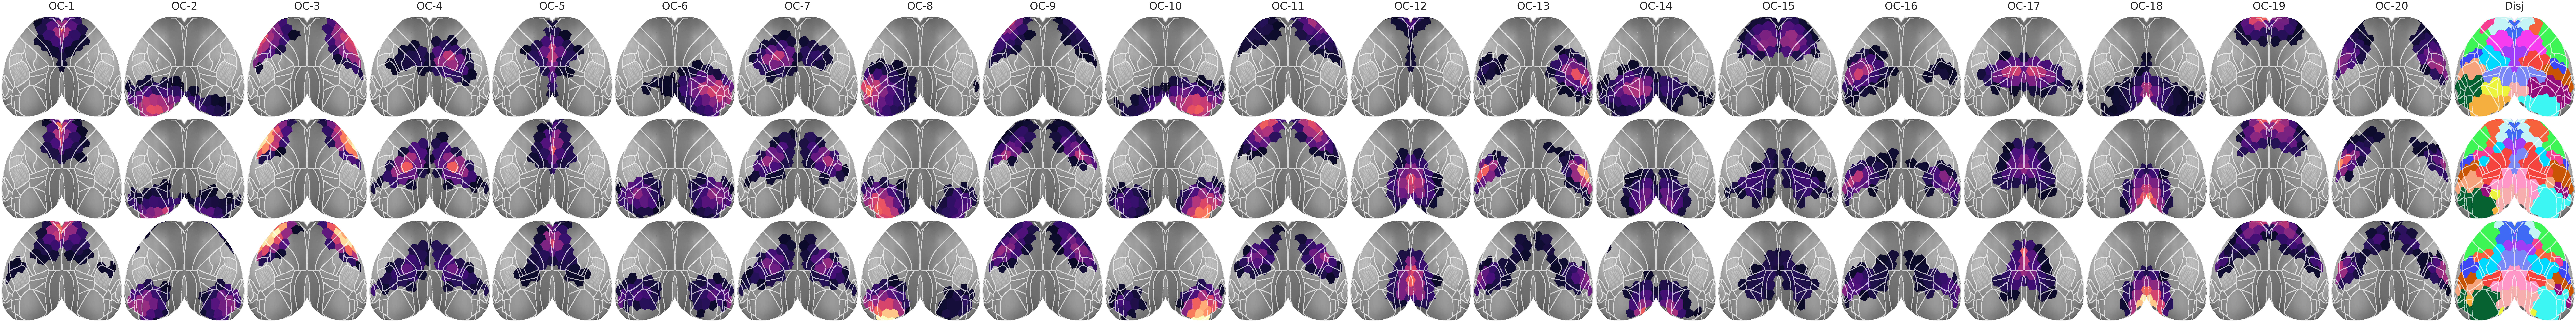

CPU times: user 14min 11s, sys: 52.7 s, total: 15min 4s
Wall time: 14min 59s


In [23]:
%%time

results = {}
for num_k in [3, 7, 20]:
    res = similiarity_results(
        mice=mice,
        perc=perc,
        num_k=num_k,
        n_resamples=int(1e4),
        merge_thres=0.376 if
        num_k == 7 else None,
        final_perm=final_perm if
        num_k == 7 else None,
    )
    results[num_k] = res

    bt = BootStrap(**res['props_ca'])
    _ = bt.show(res['pi_sorted'], **show_kws(num_k))

### Supp2A

In [24]:
res = results[3]

df = []
for mode, x in res['pi_sorted'].items():
    for i, a in enumerate(x):
        df.append({
            'mode': [mode] * len(a),
            'node': range(len(a)),
            'OC': [i + 1] * len(a),
            'pi': a,
        })
df = pd.DataFrame(merge_dicts(df))
df.to_csv(pjoin(save_dir, 'SuppFig2A.csv'), index=False)

### 2C

In [25]:
res = results[7]

df = []
for mode, x in res['pi_sorted'].items():
    for i, a in enumerate(x):
        df.append({
            'mode': [mode] * len(a),
            'node': range(len(a)),
            'OC': [i + 1] * len(a),
            'pi': a,
        })
df = pd.DataFrame(merge_dicts(df))
df.to_csv(pjoin(save_dir, 'SuppFig2C.csv'), index=False)

### 2E

In [26]:
res = results[7]

In [27]:
df = []
for mode, x in res['sim'].items():
    for i, a in enumerate(x):
        _a = np.diagonal(a)
        df.append({
            'mode': [mode] * len(_a),
            'animal': [i + 1] * len(_a),
            'OC': range(1, len(_a) + 1),
            'cos_sim': _a,
        })
df = pd.DataFrame(merge_dicts(df))

#### 2E (get pvals, concat)

In [28]:
comparison = (BOLD, CAS), (BOLD, CAF)
comparison_name = ' vs. '.join([
    f"({comparison[0][0]} vs. {comparison[0][1]})",
    f"({comparison[1][0]} vs. {comparison[1][1]})",
])
pvals = res['tests'][comparison].pvalue
pvals.shape

(7,)

## TODO: fix p vals

In [29]:
kappa = np.unique(pvals[pvals < 2e-5]).item()
kappa

1.999980000199998e-05

In [30]:
pvals[pvals <= kappa] = kappa / 10

In [31]:
pvals

array([4.01995980e-03, 1.05998940e-03, 3.19996800e-04, 1.99998000e-06,
       1.99998000e-06, 1.09998900e-03, 8.72791272e-02])

In [32]:
df_pvals = {
    'comparison': [comparison_name] * len(pvals),
    'animal': ['group'] * len(pvals),
    'OC': range(1, len(pvals) + 1),
    'p-value': pvals,
}
df_pvals = pd.DataFrame(df_pvals)

In [33]:
df = pd.concat([df, df_pvals])
df.to_csv(pjoin(save_dir, 'SuppFig2E.csv'), index=False)

### 2F

In [34]:
df = []
for kk, res in results.items():
    for (m1, m2), vals in res['sim_overall'].items():
        df.append({
            'mode1': [m1] * len(vals),
            'mode2': [m2] * len(vals),
            'K': [kk] * len(vals),
            'animal': range(1, len(vals) + 1),
            'cos_sim_overall': vals,
        })
df = pd.DataFrame(merge_dicts(df))

#### 2F (get p-vals, concat)

In [35]:
comparison = (BOLD, CAS), (BOLD, CAF)
comparison_name = ' vs. '.join([
    f"({comparison[0][0]} vs. {comparison[0][1]})",
    f"({comparison[1][0]} vs. {comparison[1][1]})",
])

In [36]:
df_pvals = []
for kk, res in results.items():
    p = res['tests_overall'][comparison].pvalue
    if p <= kappa:
        p /= 10
        print(p)
    df_pvals.append({
        'K': [kk],
        'animal': ['group'],
        'comparison': [comparison_name],
        'p-value': [p],
    })
df_pvals = pd.DataFrame(merge_dicts(df_pvals))

1.9999800001999982e-06

1.9999800001999982e-06

In [37]:
df_pvals

K 
 animal 
 comparison 
 p-value 
 
 
 
 
 0 
 3 
 group 
 (BOLD vs. Ca$^{2\!\!+}_{slow}$) vs. (BOLD vs. ... 
 0.010080 
 
 
 1 
 7 
 group 
 (BOLD vs. Ca$^{2\!\!+}_{slow}$) vs. (BOLD vs. ... 
 0.000002 
 
 
 2 
 20 
 group 
 (BOLD vs. Ca$^{2\!\!+}_{slow}$) vs. (BOLD vs. ... 
 0.000002

In [38]:
df = pd.concat([df, df_pvals])
df.to_csv(pjoin(save_dir, 'SuppFig2F.csv'), index=False)

In [39]:
combine = {
    'SuppFig2': ['A', 'C', 'E', 'F'],
}
for f, panels in combine.items():
    dfs = {}
    for p in panels:
        dfs[p] = pd.read_csv(pjoin(save_dir, f"{f}{p}.csv"))

    name = f"{f}.xlsx".replace('SuppFig', 'SupplementaryFigure')
    file = pjoin(save_dir, name)
    with pd.ExcelWriter(file) as writer:
        for p, df in dfs.items():
            df.to_excel(writer, sheet_name=f"{f}-{p}")